In [1]:
import pickle

import tensorflow as tf
import pandas as pd
import numpy as np
from annoy import AnnoyIndex
import sys
import os
%matplotlib inline



In [2]:
import tensorflow_recommenders as tfrs


In [3]:
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from deep_recommender_embeddings.src.ares import request_asset_from_ares
from deep_recommender_embeddings.src.elasticsearch_utils import get_es_instance, get_data_from_es, print_item
from deep_recommender_embeddings.src.image_embeddings import generate_image_embeddings
from deep_recommender_embeddings.src.models import ItemSimilarityModel, UserItemModel
from deep_recommender_embeddings.src.plotting import plot_metric
from deep_recommender_embeddings.src.tf_utils import get_tf_lookup_table_for_property, get_tf_lookup_for_dict
from deep_recommender_embeddings.src.inference import get_dict_of_embeddings, build_annoy_index
from deep_recommender_embeddings.src.io import export_embeddings_to_file
from deep_recommender_embeddings.src.preprocessing import load_data, clean_data, filter_logs, get_pairs, \
    get_item_pairs_from_journeys, generate_model_recs, get_pairs_location

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mercef02/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mercef02/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
%reload_ext autoreload


In [7]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


## Load content data from ES

In [8]:
_es_index = 'news_20210305c'
_es_host = 'localhost'
_es_port = '9200'
es = get_es_instance(es_host=_es_host, es_port=_es_port)

# This is the imaginary date that recommendations will be generated on
prediction_time = "2020-11-02T00:00:00"

# Business rules usually prevent recs being returned that are older than 90 days so we will only retrieve items
# that were published within this time window
max_age_days = 90

Now let's fetch all the relevant data from elasticsearch. For all items in the publication window we will fetch the id,
all the text, the tags, the category and the image url.

In [9]:
features = ["combinedBodySummaryHeadline", "tagsText", "articleCategoryName"]
hits = get_data_from_es(es, features, 50000, 5000, prediction_time, max_age_days, _es_index)
unique_item_ids = [hit['sort'][0] for hit in hits]
print(f'Grabbed {len(unique_item_ids)} items from elasticsearch')

0
1
2
3
4
5
6
7
8
9
Grabbed 42732 items from elasticsearch


### Generate tensorflow lookup tables
Tensorflow requires special lookup tables to use in its graph so here we extract the relevant information into these
objects.

In [10]:
body_lookup_table, _ = get_tf_lookup_table_for_property(hits, "combinedBodySummaryHeadline", clean=True)
tags_lookup_table, _ = get_tf_lookup_table_for_property(hits, "tagsText")
category_lookup_table, unique_categories = get_tf_lookup_table_for_property(hits, "articleCategoryName")


Tensorflow lookup table created for combinedBodySummaryHeadline with 42732 entries.
Tensorflow lookup table created for tagsText with 32987 entries.
Tensorflow lookup table created for articleCategoryName with 42631 entries.


## Load raw user data
Load the vocabulary of the of item IDs into a tensorflow dataset.

In [14]:
DATE_FIELD = 'event_start_datetime'
USER_FIELD = 'audience_id'

In [148]:
DATA_PATH = '/Users/mercef02/Projects/datasets_models/news_uk_logs_20210304/00*' #'/Users/mercef02/Projects/datasets/sfv_user_week_compact/*.csv'
logs = load_data(d_path=DATA_PATH, stop_after_n_files=100, date_field=DATE_FIELD)


In [13]:
logs.head(50)

,audience_id,visit_id,event_start_datetime,url,geo_city_site_visited
0,tLO9H7TouPBEV2ntA9PAzVncy95xUhNRZADSI/CPBqI=,115503,2021-03-04 23:38:23,https://www.bbc.co.uk/iplayer/help/iplayer-hel...,Glasgow
1,9JszSMFkcmemYVRG4daSJ0CCWoWxqRX2KymdejM2iZw=,42,2021-03-04 00:00:49,https://www.bbc.co.uk/mediacentre/latestnews,Bristol
2,s51FyBSVVL8nA5nkAYOtksDrJkyYaGmsJmqW1Z4nqGw=,32212,2021-03-04 13:01:06,https://www.bbc.co.uk/aboutthebbc/governance,Haringey
3,0Vk78MpdmAwLwU9wNu2GZxYpbljKjbL8o+8CptuEXOY=,75725,2021-03-04 22:01:01,https://www.bbc.co.uk/careers/,City of westminster
4,gV/4HfSX06SfRDuROXjI/+zOBTiVQZVVYeWsBmHt75c=,49973,2021-03-04 14:41:04,https://www.bbc.co.uk/showsandtours/shows/come...,Hoddesdon
5,adofuOlIGVIhAMysX8R3FzanZ8ivcHSf5IQxHFOJ8sY=,45102,2021-03-04 13:52:54,https://www.bbc.co.uk/iplayer/help/questions/g...,Portsmouth
6,C6zIKbLYZhkP1bYkJvsN4wsboD796b5Reui8nx6OPOc=,39091,2021-03-04 13:14:09,https://www.bbc.co.uk/showsandtours/bargain-hu...,Liverpool
7,Ihocmc4UK0YxzpOVOyjVhJRNI4eMJecBkxFfhNwCRok=,106621,2021-03-04 21:49:18,https://www.bbc.co.uk/showsandtours/shows/bank...,Nottingham
8,AELO6F5APanPNaFN9tZaFueCBU31THcDWxNkOkejaE8=,36485,2021-03-04 14:35:01,https://www.bbc.co.uk/bbcthree/article/b80a18e...,Nottingham
9,lkn4vVtgc/HUjg3cCILQPrXpb1WbuRCAep/gXmmSP14=,81615,2021-03-04 23:45:38,https://www.bbc.co.uk/mediacentre/mediapacks/k...,Coleraine


In [149]:

logs = clean_data(logs, [USER_FIELD, DATE_FIELD, 'url', 'geo_city_site_visited'], '/news/')
min_date = pd.to_datetime('2021-03-04T00:00:00')
max_date = pd.to_datetime('2021-03-04T11:59:59')
min_mentions = 5

In [18]:
logs.head()


,audience_id,event_start_datetime,geo_city_site_visited,uri
29,lpucBML/6soz1U/TcHk93BCzL/Ki+P+q6RxwKDWN4fg=,2021-03-04 02:52:31,Southwark,/news/technology-56239242
39,sPYIdNHgYJ98Gpw96yDcQgsFpeQfC0EJpPaSpVscw34=,2021-03-04 01:52:28,Manchester,/news/world-asia-55472446
158,3Lr5OzuexWD6m0bj08MikLbtjwGhj/Fc2gU3Z7tiSzY=,2021-03-04 00:35:18,Wakefield,/news/uk-56272104
159,G5pAYXT347wHjlC4ONQYVdsMAwSFtl1ysjRud0XE2n8=,2021-03-04 00:50:39,Omagh,/news/uk-56267807
160,rE3xy1mrmqGZ7P77YYs7y+e3/VqH+zu2Pp0Btu3Tp34=,2021-03-04 00:07:06,Stockton-on-tees,/news/business-56263581


In [150]:
train_logs = filter_logs(logs, min_date, max_date, min_mentions, unique_item_ids, DATE_FIELD)

Original interactions: 22851008
Date filtered interactions: 9115759
Minimum mention filtered interactions  : 9034916
Interactions filtered for items existing in ES : 7677652


In [443]:
def show_most_pop_for_region(logs, region, n, d=True, summary=False):
    
    regional_logs = logs[logs.geo_city_site_visited == region]
    counts = regional_logs.uri.value_counts()[:n]
    if d:
        print(counts)
    
    if summary:
        for i, rec in enumerate(counts.index.to_numpy()):
            print(f'({i})')
            print_item(rec, es, _es_index)
            print(f'-------------------')
            
        
    return counts
    


In [21]:
train_logs.head()

,audience_id,event_start_datetime,geo_city_site_visited,uri
29,lpucBML/6soz1U/TcHk93BCzL/Ki+P+q6RxwKDWN4fg=,2021-03-04 02:52:31,Southwark,/news/technology-56239242
39,sPYIdNHgYJ98Gpw96yDcQgsFpeQfC0EJpPaSpVscw34=,2021-03-04 01:52:28,Manchester,/news/world-asia-55472446
158,3Lr5OzuexWD6m0bj08MikLbtjwGhj/Fc2gU3Z7tiSzY=,2021-03-04 00:35:18,Wakefield,/news/uk-56272104
159,G5pAYXT347wHjlC4ONQYVdsMAwSFtl1ysjRud0XE2n8=,2021-03-04 00:50:39,Omagh,/news/uk-56267807
160,rE3xy1mrmqGZ7P77YYs7y+e3/VqH+zu2Pp0Btu3Tp34=,2021-03-04 00:07:06,Stockton-on-tees,/news/business-56263581


In [166]:
location_vocab=np.array(train_logs.geo_city_site_visited.unique())

In [498]:
location_counts = train_logs['geo_city_site_visited'].value_counts()

In [503]:
location_counts.head(30)

London                    219608
Bristol                   133463
Edinburgh                 125059
Manchester                117682
Birmingham                114471
Newbury                   109809
Nottingham                107409
Glasgow                   103978
Maidenhead                 92076
Waltham forest             82455
Sheffield                  74195
Southwark                  74173
Liverpool                  68904
Leeds                      63410
Hammersmith and fulham     61201
Wembley                    59812
Cardiff                    58198
Belfast                    58183
Tower hamlets              57662
Wandsworth                 54044
Lambeth                    52714
Cambridge                  51933
Leicester                  50072
New addington              49948
Barnet                     46992
Camden                     45860
Norwich                    45403
Haringey                   43104
Oxford                     42922
Southampton                42525
Name: geo_

<AxesSubplot:>

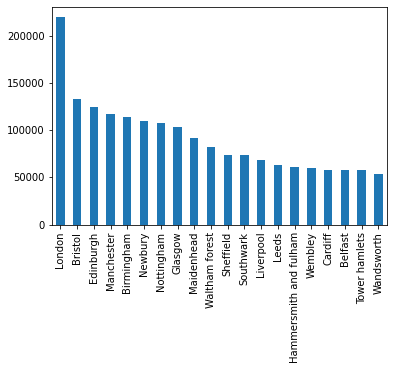

In [502]:
location_counts.iloc[:20].plot(kind='bar')

In [167]:
len(location_vocab)

4375

### Generate useritem pairs 
The input for the model is pairs of consecutively consumed items so next we need to convert the journeys into item pairs

In [163]:
WINDOW=50 # this is the max distance in a user journey between pairs
 
train_pairs = get_item_pairs_from_journeys(train_logs, window=WINDOW, date_field=DATE_FIELD, pair_function=get_pairs_location)
train_pairs_df = pd.DataFrame(train_pairs)
train_logs_tf = tf.data.Dataset.from_tensor_slices(dict(train_pairs_df))

Total number of item pairs: 14510735


## Train/Test Split

In [544]:
tf.random.set_seed(42)
training_shuffled = train_logs_tf.shuffle(buffer_size=100_000, seed=42, reshuffle_each_iteration=False)
train_pc = 0.995
test_pc = 0.005
news_train = training_shuffled.take(np.floor(len(training_shuffled)*train_pc))
news_val = training_shuffled.skip(np.floor(len(training_shuffled)*train_pc)).take(np.floor(len(training_shuffled)*test_pc))

print(f'Number of train pairs: {len(news_train)}')
print(f'Number of test pairs: {len(news_val)}')

Number of train pairs: 14438181
Number of test pairs: 72553


Epoch 1/2
14100/14100 [==============================] - 17862s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0032 - factorized_top_k/top_5_categorical_accuracy: 0.0246 - factorized_top_k/top_10_categorical_accuracy: 0.0432 - factorized_top_k/top_50_categorical_accuracy: 0.1492 - factorized_top_k/top_100_categorical_accuracy: 0.2172 - loss: 6.9334 - regularization_loss: 0.0000e+00 - total_loss: 6.9334 - val_factorized_top_k/top_1_categorical_accuracy: 0.0020 - val_factorized_top_k/top_5_categorical_accuracy: 0.0109 - val_factorized_top_k/top_10_categorical_accuracy: 0.0223 - val_factorized_top_k/top_50_categorical_accuracy: 0.2169 - val_factorized_top_k/top_100_categorical_accuracy: 0.3421 - val_loss: 6.9350 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6.9350
Epoch 2/2
14100/14100 [==============================] - 26533s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0014 - factorized_top_k/top_5_categorical_accuracy: 0.0057 - factorized_top_k/top_10_ca

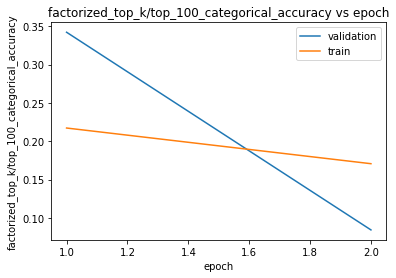

In [545]:
num_epochs = 2
lr = 0.05
cached_train = news_train.batch(1024).cache()
cached_test = news_val.batch(1024).cache()

model_one_layer = UserItemModel(test_candidate_ids=unique_item_ids,
                   user_features=['location'],
                   user_feature_dims=[100],
                   location_vocab=location_vocab,
                   user_layer_sizes=[],
                   item_features=['item_id'],
                   item_feature_dims=[200, 400],
                   item_unique_item_ids=unique_item_ids,
                   item_item_body_lookup=body_lookup_table,
                   item_layer_sizes=[100],
                   compute_metrics=True
                               )
    

model_one_layer.compile(optimizer=tf.keras.optimizers.Adagrad(lr))

one_layer_history = model_one_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=num_epochs,
    verbose=1)

print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')
plot_metric(one_layer_history, 'factorized_top_k/top_100_categorical_accuracy')

In [ ]:
print(f'Train accuracy: {one_layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]}')   
print(f'Validation accuracy: {one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]}')
plot_metric(one_layer_history, 'factorized_top_k/top_100_categorical_accuracy')

In [219]:
def get_location_embedding(model, location_string):
    ds = tf.data.Dataset.from_tensor_slices(
    {"user_location": [location_string]}) 
    return model.predict(ds.batch(1))

In [538]:
save_embeddings_fpath = '../data/embeddings/trained/location_user100_item_512_256full.pkl'
item_embeddings = get_dict_of_embeddings(model_one_layer, unique_item_ids)
export_embeddings_to_file(item_embeddings, save_embeddings_fpath)
annoy_index, id_to_uri, uri_to_id = build_annoy_index(item_embeddings)

In [452]:
def show_siamese_model_recs(model, location, n):
    vec = get_location_embedding(model_one_layer.user_model, location)[0]
    rec_uris = generate_model_recs(annoy_index, uri_to_id, id_to_uri, item_embeddings, es, _es_index, n, query_vector=vec)
    #print(f'LITMUS TEST: {groundtruth_uri in rec_uris}')
    print('-------------------')
    print('-------------------')

    for i, rec in enumerate(rec_uris):
        print(f'({i+1})')
        print_item(rec, es, _es_index)
        print('-------------------')

In [541]:
show_siamese_model_recs(model_one_layer, 'Belfast', 20)

Generating recommendations for:
-------------------
-------------------
-------------------
-------------------
(1)
/news/world-europe-56278125 
 Arlene Foster says the EU is ignoring unionist concerns, but Michelle O'Neill says Number 10 is acting in bad faith.
-------------------
(2)
/news/world-europe-56212487 
 The emergence of the Irish revolutionary's bright blue plush puppies stunned Irish Twitter users.
-------------------
(3)
/news/uk-scotland-56280065 
 The stamp duty holiday on house purchases was extended in the Westminster budget but will end in Scotland.
-------------------
(4)
/news/business-55816139 
 There is 'unfairness in some of the millions excluded from government help, research for the BBC finds.
-------------------
(5)
/news/explainers-53724381 
 What is the plan to stop border checks in Northern Ireland?
-------------------
(6)
/news/uk-scotland-north-east-orkney-shetland-56268489 
 Thirty-four passengers on the flight from London to Aberdeen have yet to be tra

In [531]:
show_most_pop_for_region(train_logs, 'York', 20)

/news/uk-56275888                             3051
/news/health-56271627                         2091
/news/technology-56266494                     1389
/news/uk-56278445                             1283
/news/business-56275415                       1114
/news/blogs-the-papers-56274693               1097
/news/business-56271295                       1009
/news/world-us-canada-56275103                1005
/news/business-56276953                        821
/news/uk-england-northamptonshire-56274524     768
/news/world-us-canada-56275335                 716
/news/uk-politics-56274711                     644
/news/uk-51768274                              588
/news/health-56274293                          555
/news/business-56263581                        555
/news/entertainment-arts-56278135              502
/news/uk-england-sussex-56268078               488
/news/blogs-trending-56260345                  477
/news/business-56209011                        468
/news/world-europe-56270508    

/news/uk-56275888                             3051
/news/health-56271627                         2091
/news/technology-56266494                     1389
/news/uk-56278445                             1283
/news/business-56275415                       1114
/news/blogs-the-papers-56274693               1097
/news/business-56271295                       1009
/news/world-us-canada-56275103                1005
/news/business-56276953                        821
/news/uk-england-northamptonshire-56274524     768
/news/world-us-canada-56275335                 716
/news/uk-politics-56274711                     644
/news/uk-51768274                              588
/news/health-56274293                          555
/news/business-56263581                        555
/news/entertainment-arts-56278135              502
/news/uk-england-sussex-56268078               488
/news/blogs-trending-56260345                  477
/news/business-56209011                        468
/news/world-europe-56270508    

In [ ]:
all_data = train_logs 
location = 'Belfast'
n=20
min_


location_data = data[data.geo_city_site_visited == location]
location_article_reads = location_data[['uri', 'geo_city_site_visited']].groupby('uri').count()

likelihood_reads_given_location = get_likelihood_reads(location_data, article_reads['audience_id'])
likelihood_reads = get_likelihood_reads(data, article_reads['audience_id'])
likilihood_of_location = get_prior_for_location(data, location_data)

probabilities = (likelihood_reads_given_location * likilihood_of_location) / likelihood_reads

article_reads = data.groupby('uri').count()
article_reads['location_posterior'] = probabilities
article_reads = article_reads.sort_values(by='location_posterior', ascending=False)

# Naive Bayes Model

In [481]:
# For each article, we want to calculate the posterior probability that the article is relevant to a region.

# So Bayes theorem: P(model| data) = P(data|model) * P(model) / P(data)
# This can be translated into:
# P(Bristol relevant| Article reads) = P(Article reads | Bristol relevant) * P(Bristol relevant) / P(reads)


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV


def build_kde_model(samples):
    samples = samples.reshape((len(samples), 1))
    model = KernelDensity(bandwidth=0.2, kernel='gaussian')
    model.fit(samples)
    return model
    
def probability_of_value(model, values):
    values = np.asarray(values).reshape((len(values), 1))
    probabilities = np.exp(model.score_samples(values))
    return probabilities

def get_posterior_for_location(n_reads, location_data, data):
    likelihood_reads_given_location = get_likelihood_reads(location_data, n_reads)
    likelihood_reads = get_likelihood_reads(data, n_reads)
    likilihood_of_location = get_prior_for_location(data, location_data)
    
    posterior = (likelihood_reads_given_location * likilihood_of_location) / likelihood_reads
    return {'posterior': posterior, "likelihood_reads": likelihood_reads, "likelihood_reads_given_loc": likelihood_reads_given_location}

def get_likelihood_reads(data, reads):
    samples = data.groupby('uri').count()['audience_id'].to_numpy()
    log_samples = np.log(samples)
    model = build_kde_model(log_samples)
    log_reads = np.log(reads)
    return probability_of_value(model, log_reads)

def get_prior_for_location(data, location_data):
    #location_vocab=np.array(data.geo_city_site_visited.unique())
    #return 1/len(location_vocab)
    return len(location_data)/len(data)

def show_naive_bayes_for_location(all_data, location, n, min_reads):
    location_data = data[data.geo_city_site_visited == location]
    location_article_reads = location_data[['uri', 'geo_city_site_visited']].groupby('uri').count()
    location_article_reads = location_article_reads[location_article_reads['geo_city_site_visited'] > min_reads]
    probabilities = get_posterior_for_location(location_article_reads['geo_city_site_visited'], location_data, all_data)
    location_article_reads['location_posterior'] = probabilities['posterior']
    location_article_reads['likelihood_reads'] = probabilities['likelihood_reads']
    location_article_reads['likelihood_reads_given_loc'] = probabilities['likelihood_reads_given_loc']
    location_article_reads = location_article_reads.sort_values(by='location_posterior', ascending=False)
    
    for i, rec in enumerate(location_article_reads.index.to_numpy()[:n]):
        print(f'{i+1}')
        print_item(rec, es, _es_index)
        print('-------------------')
        #print(location_article_reads.sort_values(by='location_posterior', ascending=False)['location_posterior'][:n])
    
    return location_article_reads
 

In [300]:
samples = data.groupby('uri').count()['audience_id'].to_numpy()

In [464]:
# log_samples = np.log(samples)
# grid = GridSearchCV(KernelDensity(),
#                         {'bandwidth': np.linspace(0.01, 2, 20)},
#                     cv=20) # 20-fold cross-validation
# grid.fit(log_samples)
# print(grid.best_params_)

model = KernelDensity(bandwidth=2.0, kernel='gaussian')
model.fit(log_samples)

KernelDensity(bandwidth=2.0)

In [493]:
ps = probability_of_value(model, np.arange(0,15))

In [494]:
grid.best_params_['bandwidth']

0.01

In [495]:
ps.sum()

0.939992319343563

In [467]:
probability_of_value(model, np.log([1]))

array([0.0734425])

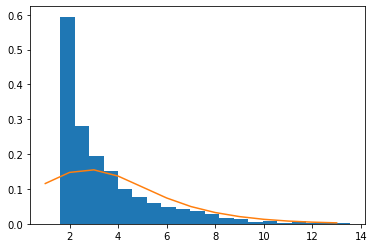

In [468]:
# plot the histogram and pdf
pyplot.hist(log_samples, bins=20, density=True)
pyplot.plot(np.arange(0,14), ps)
pyplot.show()

In [371]:
np.log(samples)

array([[ 5.43807931],
       [ 4.12713439],
       [ 3.21887582],
       ...,
       [ 7.12447826],
       [12.38829836],
       [12.11232225]])

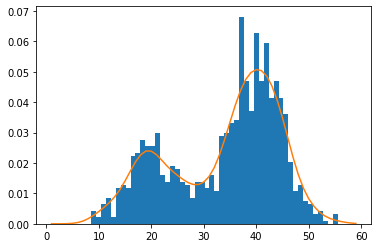

In [370]:
# example of kernel density estimation for a bimodal data sample
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
# generate a sample
sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)
sample = hstack((sample1, sample2))
# fit density
model = KernelDensity(bandwidth=2, kernel='gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)
# sample probabilities for a range of outcomes
values = asarray([value for value in range(1, 60)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = exp(probabilities)
# plot the histogram and pdf
pyplot.hist(sample, bins=50, density=True)
pyplot.plot(values[:], probabilities)
pyplot.show()

In [296]:
all_reads = train_logs[['uri', 'geo_city_site_visited']].groupby('uri').count()

In [298]:
all_reads.loc['/news/uk-56275888']

geo_city_site_visited    755633
Name: /news/uk-56275888, dtype: int64

In [431]:
a_reads.head(20)

,geo_city_site_visited,location_posterior,likelihood_reads,likelihood_reads_given_loc
uri,,,,
/news/uk-56275888,5247,0.163119,0.002113,0.045489
/news/technology-56246852,355,0.054056,0.016300,0.116267
/news/uk-england-sussex-56268078,357,0.044223,0.021949,0.128083
/news/uk-northern-ireland-56216762,358,0.034092,0.026932,0.121160
/news/uk-northern-ireland-56276653,4583,0.032634,0.010564,0.045489
/news/world-europe-56269905,1411,0.028243,0.012212,0.045512
/news/business-56246848,235,0.023194,0.035701,0.109267
/news/entertainment-arts-56278135,745,0.021164,0.016691,0.046613
/news/uk-56278445,1783,0.020532,0.016829,0.045596


In [505]:

a = show_most_pop_for_region(train_logs, 'Wandsworth', 20, d=False, summary=True)

(0)
/news/uk-56275888 
 The Duchess of Sussex says she does not know how Buckingham Palace could expect her to "be silent".
-------------------
(1)
/news/technology-56266494 
 The shop will stock hundreds of new own-brand items including UK-sourced milk and desserts.
-------------------
(2)
/news/health-56271627 
 Infections fell by two-thirds in lockdown but one in 200 people still have the virus, a study says.
-------------------
(3)
/news/uk-56278445 
 The Duke of Edinburgh will remain in hospital for a number of days, Buckingham Palace says.
-------------------
(4)
/news/business-56271295 
 There's more support for many in the Budget, but for some it still falls short.
-------------------
(5)
/news/business-56276953 
 The Budget leaves the chancellor looking more Scrooge than Santa, says the Institute for Fiscal Studies.
-------------------
(6)
/news/business-56275415 
 About 200,000 pensions may get top-ups averaging £13,500 after nearly two decades of shortfalls.
----------------

In [543]:
a_reads = show_naive_bayes_for_location(train_logs, 'Manchester', 20, 100)

1
/news/uk-england-sussex-56268078 
 Whoever took the slabs had "made a right old mess", according to local resident Alan Stainer.
-------------------
2
/news/uk-england-oxfordshire-56262712 
 The Labour party investigates after Jamila Azad claimed to have been vaccinated by a private doctor.
-------------------
3
/news/entertainment-arts-56277845 
 The actor made light of a recent controversy surrounding the heritage of his wife, Hilaria.
-------------------
4
/news/uk-51768274 
 Explore the data on coronavirus in the UK and find out how many cases there are in your area.
-------------------
5
/news/uk-56272104 
 Buckingham Palace is "very concerned" by a report that royal staff made a complaint about the duchess.
-------------------
6
/news/business-56272829 
 Forecasts suggests inheritance tax receipts will also rise, partly due to over-65s dying of Covid
-------------------
7
/news/blogs-trending-56260345 
 Believers are using an old, irrelevant law to herald the supposed return to

In [507]:
show_siamese_model_recs(model_one_layer, 'Wandsworth', 20)

Generating recommendations for:
-------------------
-------------------
-------------------
-------------------
(1)
/news/entertainment-arts-55853625 
 The film, which was first shown 50 years ago and locked away, re-appeared this month on YouTube.
-------------------
(2)
/news/uk-politics-55607160 
 The Labour leader urges ministers to give councils more money instead to protect family budgets.
-------------------
(3)
/news/uk-scotland-edinburgh-east-fife-56267417 
 Her 63-year-old husband died in an ambulance after being crushed at work in Whitburn, West Lothian.
-------------------
(4)
/news/uk-england-beds-bucks-herts-56274523 
 Announcing the event, the festival's founder says this year's is "more important than ever".
-------------------
(5)
/news/world-asia-55472446 
 An archaic Japanese law requires married couples to adopt the same surname, but many are asking why.
-------------------
(6)
/news/world-us-canada-56273381 
 Governor Cuomo said he will not resign amidst allegation

In [231]:
a_reads.head(20)

,audience_id,event_start_datetime,geo_city_site_visited,location_posterior
uri,,,,
/news/uk-56141867,851,851,851,0.049758
/news/business-56130187,1540,1540,1540,0.028885
/news/world-europe-56250460,1233,1233,1233,0.026646
/news/uk-wales-56165569,960,960,960,0.024441
/news/uk-england-norfolk-54452133,1271,1271,1271,0.024060
/news/technology-56251452,1091,1091,1091,0.023929
/news/business-55765868,1469,1469,1469,0.023130
/news/uk-wales-55333756,812,812,812,0.021045
/news/entertainment-arts-56247655,763,763,763,0.019500


In [106]:


article_reads = train_logs.groupby('uri').count()
article_reads.head()

,audience_id,event_start_datetime,geo_city_site_visited
uri,,,
/news/20039682,13,13,13
/news/53498434,205,205,205
/news/55669736,26,26,26
/news/55733537,19,19,19
/news/55831263,8,8,8


In [35]:
probabilities = get_posterior_for_location(article_reads['audience_id'], 'Bristol', train_logs)

In [109]:
article_reads['bristol_posterior'] = probabilities

In [132]:
a = article_reads.sort_values(by='bristol_posterior', ascending=False)

In [133]:
a.head()

,audience_id,event_start_datetime,geo_city_site_visited,bristol_posterior
uri,,,,
/news/uk-politics-55738179,151,151,151,0.076511
/news/uk-scotland-north-east-orkney-shetland-56268489,397,397,397,0.041443
/news/uk-56147693,131,131,131,0.035477
/news/business-56270528,130,130,130,0.030915
/news/uk-england-cornwall-56258552,149,149,149,0.030196


In [138]:
a.index.to_numpy()

array(['/news/uk-politics-55738179',
       '/news/uk-scotland-north-east-orkney-shetland-56268489',
       '/news/uk-56147693', ..., '/news/uk-northern-ireland-56262527',
       '/news/uk-england-oxfordshire-56262712',
       '/news/world-us-canada-56275335'], dtype=object)

In [95]:
uris['id'] = np.arange(len(uris))

In [100]:
uri_to_id = uris['id'].to_dict()
id_to_uri = {v: k for k, v in uri_to_id.items()}

In [102]:

location_counts = train_logs.groupby('geo_city_site_visited').count()
location_counts['id'] = np.arange(len(location_counts))

In [103]:
loc_to_id = location_counts['id'].to_dict()
id_to_loc = {v: k for k, v in loc_to_id.items()}

In [90]:
location_counts.loc['York']['id']

3176

In [104]:
train_logs['loc_id'] = train_logs['geo_city_site_visited'].apply(lambda x: loc_to_id[x])

In [106]:
train_logs['uri_id'] = train_logs['uri'].apply(lambda x: uri_to_id[x])

In [118]:
train_logs['bristol_y'] = train_logs['geo_city_site_visited']=='Bristol'


In [119]:
train_logs.head()

,audience_id,event_start_datetime,uri,geo_city_site_visited,loc_id,uri_id,bristol_y
29,lpucBML/6soz1U/TcHk93BCzL/Ki+P+q6RxwKDWN4fg=,2021-03-04 02:52:31,/news/technology-56239242,Southwark,2589,302,False
39,sPYIdNHgYJ98Gpw96yDcQgsFpeQfC0EJpPaSpVscw34=,2021-03-04 01:52:28,/news/world-asia-55472446,Manchester,1874,872,False
158,3Lr5OzuexWD6m0bj08MikLbtjwGhj/Fc2gU3Z7tiSzY=,2021-03-04 00:35:18,/news/uk-56272104,Wakefield,2920,389,False
159,G5pAYXT347wHjlC4ONQYVdsMAwSFtl1ysjRud0XE2n8=,2021-03-04 00:50:39,/news/uk-56267807,Omagh,2155,386,False
160,rE3xy1mrmqGZ7P77YYs7y+e3/VqH+zu2Pp0Btu3Tp34=,2021-03-04 00:07:06,/news/business-56263581,Stockton-on-tees,2662,115,False


In [112]:
loc_to_id['York']

3176

In [117]:
clf.predict(np.array([[3176, 439]]))

array([1.])

In [127]:
Y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [130]:
from sklearn.naive_bayes import GaussianNB

X = train_logs[['uri_id']].to_numpy()
Y = train_logs[['bristol_y']].to_numpy()*1
clf = GaussianNB()
clf.fit(X, np.ravel(Y))

GaussianNB()

In [135]:

clf.predict(np.array([[429]]))

array([0])

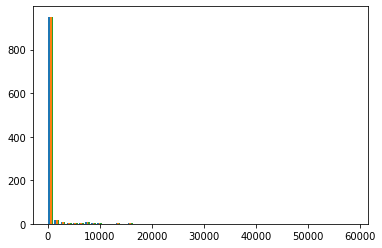

In [34]:

# example of a bimodal data sample
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
# generate a sample


# plot the histogram
pyplot.hist(sample, bins=50)
pyplot.show()

In [84]:
from sklearn.neighbors import KernelDensity 

def build_kde_model(samples):
    model = KernelDensity(bandwidth=1, kernel='gaussian')
    samples = sample.reshape((len(samples), 1))
    model.fit(samples)
    return model
    
def probability_of_value(model, values):
    values = np.asarray(values).reshape((len(values), 1))
    probabilities = np.exp(model.score_samples(values))
    return probabilities
    

In [85]:
# sample probabilities for a range of outcomes
values = [value for value in np.arange(60000)]
sample = uris['audience_id'].to_numpy()
model = build_kde_model(sample)
probabilities = probability_of_value(model, values)


In [90]:
probability_of_value(model, [6000])

array([0.])

In [87]:
sample

array([   13,   205,    26, ...,    99, 17088, 13331])

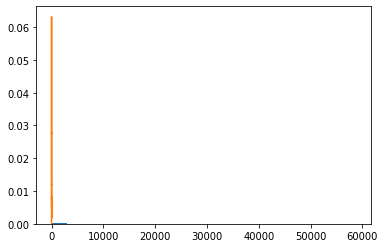

In [88]:

# plot the histogram and pdf
pyplot.hist(sample, bins=20, density=True)
pyplot.plot(values[:50], probabilities[:50])
pyplot.show()

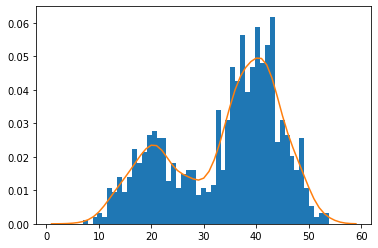

In [311]:
# example of kernel density estimation for a bimodal data sample
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
# generate a sample
sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)
sample = hstack((sample1, sample2))
# fit density
model = KernelDensity(bandwidth=2, kernel='gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)
# sample probabilities for a range of outcomes
values = asarray([value for value in range(1, 60)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = exp(probabilities)
# plot the histogram and pdf
pyplot.hist(sample, bins=50, density=True)
pyplot.plot(values[:], probabilities)
pyplot.show()

In [347]:
len(sample)

1000

In [313]:
exp(model.score_samples(np.array([[40]])))

array([0.04945435])

In [315]:
values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59])

In [316]:
values = values.reshape((len(values), 1))

In [319]:
res = np.exp(model.score_samples(values))
res.sum()

0.9999942780229238